In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, recall_score, precision_score
from itertools import product
from joblib import Parallel, delayed

In [2]:
from src.data.data_loader import extract_features_labels
X, y = extract_features_labels()

HOLD - OUT

In [4]:
# Chạy 1500 tổ hợp: 10 x 15 x 10
param_grid = {
    'max_depth': list(range(3, 11)),
    'min_samples_split': list(range(5, 20)),
    'min_samples_leaf': list(range(2, 11)),
}

num_iterations = 100  # Lặp 100 lần mỗi tổ hợp
random_state_base = 42

combos = []
for max_depth, min_samples_split, min_samples_leaf in product(
    param_grid['max_depth'],
    param_grid['min_samples_split'],
    param_grid['min_samples_leaf']
):
    if min_samples_leaf >= min_samples_split:
        continue
    combos.append({
        'max_depth': max_depth,
        'min_samples_split': min_samples_split,
        'min_samples_leaf': min_samples_leaf
    })


def evaluate_combo(params):
    f1_scores = []
    precision_scores = []
    recall_scores = []

    sss = StratifiedShuffleSplit(n_splits=num_iterations, test_size=0.2, random_state=42)
    for split_id, (train_idx, test_idx) in enumerate(sss.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

        model = DecisionTreeClassifier(
            max_depth=params['max_depth'],
            min_samples_split=params['min_samples_split'],
            min_samples_leaf=params['min_samples_leaf'],
            random_state=random_state_base + split_id,
            criterion='gini',
            max_features='sqrt',
            class_weight='balanced',
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        f1_scores.append(f1_score(y_test, y_pred, average='binary'))
        precision_scores.append(precision_score(y_test, y_pred, average='binary'))
        recall_scores.append(recall_score(y_test, y_pred, average='binary'))

    return {
        **params,
        'mean_f1': np.mean(f1_scores),
        'std_f1': np.std(f1_scores),
        'mean_precision': np.mean(precision_scores),
        'std_precision': np.std(precision_scores),
        'mean_recall': np.mean(recall_scores),
        'std_recall': np.std(recall_scores)
    }

# Tính toán
results = Parallel(n_jobs=-1)(
    delayed(evaluate_combo)(params) for params in combos
)

# Kết quả
df_result = pd.DataFrame(results)
df_result_sorted = df_result.sort_values(by='mean_f1', ascending=False)

In [5]:
df_result_sorted

,max_depth,min_samples_split,min_samples_leaf,mean_f1,std_f1,mean_precision,std_precision,mean_recall,std_recall
570,8,5,2,0.883541,0.044091,0.905887,0.041948,0.866207,0.072542
798,10,5,2,0.881102,0.045862,0.902719,0.042998,0.864483,0.074319
684,9,5,2,0.880604,0.045551,0.902000,0.042542,0.864138,0.073928
573,8,6,2,0.880324,0.046411,0.903737,0.042552,0.861724,0.073229
456,7,5,2,0.879918,0.049308,0.906178,0.042249,0.858966,0.076966
...,...,...,...,...,...,...,...,...,...
80,3,16,4,0.820133,0.076878,0.921510,0.053893,0.750345,0.120948
71,3,15,4,0.820033,0.076261,0.921411,0.054098,0.750000,0.119688
62,3,14,4,0.819699,0.075983,0.921089,0.054493,0.749655,0.119215
106,3,19,3,0.818699,0.071421,0.920170,0.054675,0.748276,0.116069


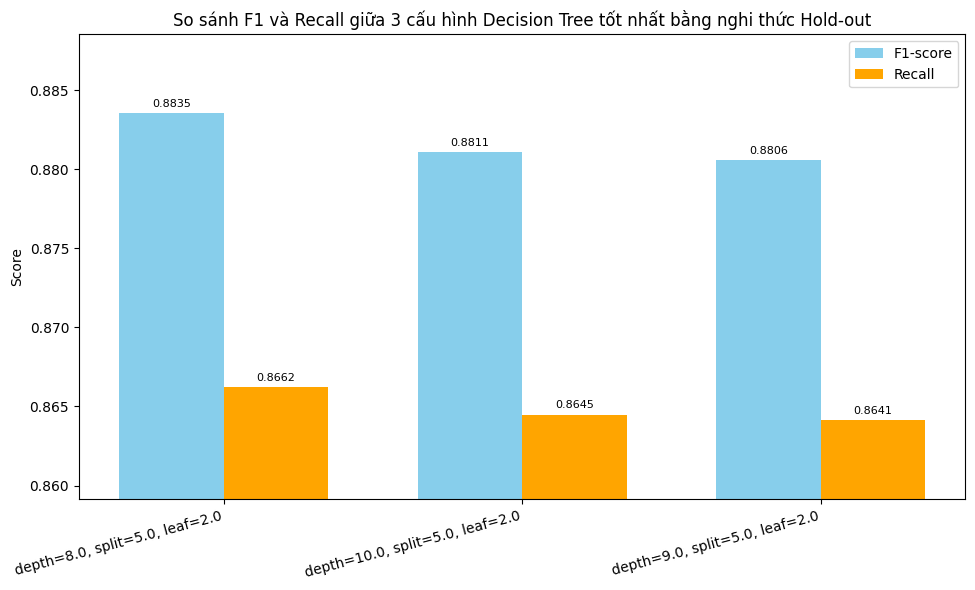

In [6]:
top3 = df_result_sorted.head(3).copy()

top3['label'] = top3.apply(
    lambda row: f"depth={row['max_depth']}, split={row['min_samples_split']}, leaf={row['min_samples_leaf']}", axis=1)

x = np.arange(len(top3))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width / 2, top3['mean_f1'], width, label='F1-score', color='skyblue')
rects2 = ax.bar(x + width / 2, top3['mean_recall'], width, label='Recall', color='orange')

ax.set_ylabel('Score')
ax.set_title('So sánh F1 và Recall giữa 3 cấu hình Decision Tree tốt nhất bằng nghi thức Hold-out')
ax.set_xticks(x)
ax.set_xticklabels(top3['label'], rotation=15, ha='right')
ax.legend()

min_y = min(top3['mean_f1'].min(), top3['mean_recall'].min()) - 0.005
max_y = max(top3['mean_f1'].max(), top3['mean_recall'].max()) + 0.005
ax.set_ylim(min_y, max_y)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.4f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()